In [268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [269]:
#import data
user = pd.read_csv('takehome_users.csv',encoding= 'iso8859',parse_dates=['creation_time'])
engagement = pd.read_csv('takehome_user_engagement.csv',parse_dates=['time_stamp'])

In [270]:
#isolate user description to clean up data
user_desc = user[['object_id','creation_time','name','email']]

#remove from primary df
user.drop(columns=['creation_time','name','email'],inplace=True)

## Data Exploration

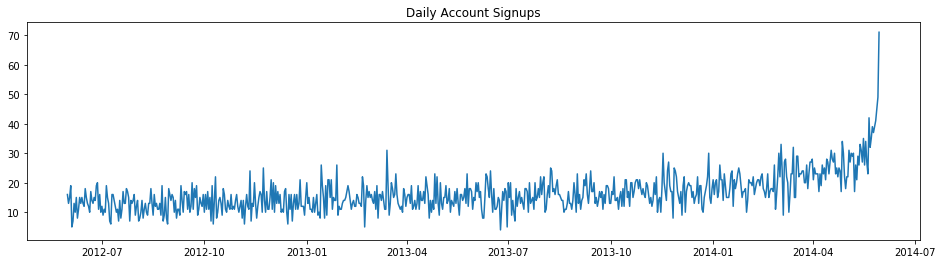

In [271]:
#checking sign up rates
creation_time = user_desc.set_index('creation_time')

plt.figure(figsize=(16,4))
plt.title('Daily Account Signups')
plt.plot(creation_time.resample('D').name.count())
plt.show()

Signup rates have mostly been on a subtle trend upwards until beginning of 2014 and then shows a definite upward slope with May, 2014 signup is almost three times that of last year.

In [272]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
object_id                     12000 non-null int64
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 656.3+ KB


**object_id** is our user id <br>
**creation_source** is a categorical variable to be encoded<br>
**last_session_creation_time** is a unix timestamp that will be converted to pandas datetime<br>
*Null values could indicate missing data or never logged on.
  

**opted_in_to_mailing_list** is a binary integer <br>
**enabled_for_marketing_drop** is a binary integer<br>
**org_id** is the org id for the user<br>
**invited_by_user_id** is also user id column.<br>
*Null values indicate no invites.

### last_session_creation_time

Tackling into this feature first, since we have the engagement df, we can find out if those users with null last_session_creation_time have ever logged in to use the product.<br>
This is to determine whether the null data is missing data or correct data.

In [273]:
#retrieve user id with null last session creation time
null_last_session= user.loc[~user.last_session_creation_time.notnull()].object_id

#select engagement records with the above user id
engagement.loc[engagement.user_id.isin(null_last_session)]

,time_stamp,user_id,visited


As there are no engagement logs from the missing user ids, null entries for this feature indicates no user activity.

### invited_by_user_id

Description of the dataframe already stated that this feature will contain a value if applicable meaning null values simply mean no invites.<br>For this problem, we will simplify this field to indication of invited rather than who invited.

In [274]:
import math
#simplify invited
user['invited'] = [0 if math.isnan(x) else 1 for x in user['invited_by_user_id']]

In [276]:
#join the invited_user_id to user_desc df and remove
user_desc=user_desc.join(user.invited_by_user_id)

user.drop(columns=['invited_by_user_id'],inplace=True)

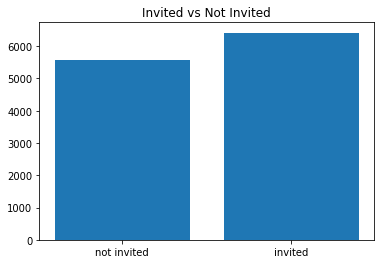

In [277]:
#plot for invited
plt.title('Invited vs Not Invited',fontsize=12)
plt.bar(['not invited','invited'],user.groupby('invited').invited.count().values)
plt.show()

### engagement time_stamp

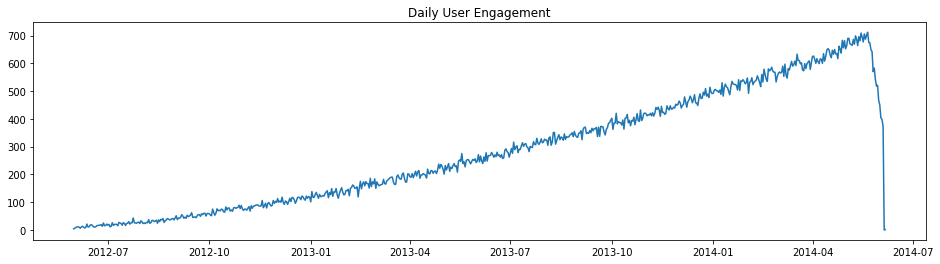

In [278]:
#reset index to time of engagement
eng_time = engagement.set_index('time_stamp')

#plot charts for user engagement
plt.figure(figsize=(16,4))
plt.title('Daily User Engagement')
plt.plot(eng_time.resample('D').visited.count())
plt.show()

Steady increase in overall engagement is seen however, there is a sharp in june.

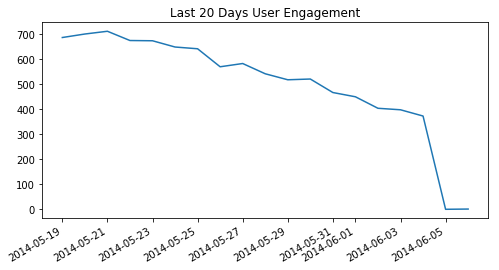

In [279]:
plt.figure(figsize=(8,4))
plt.title('Last 20 Days User Engagement')
plt.plot(eng_time.resample('D').visited.count()[-1:-20:-1])
plt.gcf().autofmt_xdate()
plt.show()

## Data Wrangling

**creation_source**

In [280]:
#feature engineer to encode city
one_hot = pd.get_dummies(user['creation_source'])

In [281]:
user = user.join(one_hot)

In [282]:
#drop city
user.drop(['creation_source'],axis=1,inplace=True)

#rename for easy identification
user.rename(columns={"GUEST_INVITE": "src_guest_invite", "ORG_INVITE": "src_org_invite", 
                     "PERSONAL_PROJECTS":"src_personal_projects", "SIGNUP":"src_signup",
                    "SIGNUP_GOOGLE_AUTH":"src_signup_google_auth"},inplace=True)
print('')

**last_session_creation_time**

In [283]:
#convert unix timestamp to pandas datetime
user['last_session'] = pd.to_datetime(user['last_session_creation_time'],unit='s')

In [284]:
#remove 
user_desc = user_desc.join(user.last_session_creation_time)

user.drop(columns=['last_session_creation_time'],inplace=True)

**org_id**

All users are bound to an org_id therefore adopted user prediction is not dependent on whether a user belongs to an org or not. 

In [285]:
#remove and append
user_desc=user_desc.join(user.org_id)

user.drop(columns=['org_id'], inplace=True)

**object_id**

Our object_id is the user_id and will serve as index.

In [286]:
user.set_index('object_id',inplace=True)
print('')

**last_session_creation_time**

As discussed above, null last_session_creation_time indicates users that have signed up but never joined a single session also known as ghost users. <br> These user data will only introduce noise in predicting the adopted users out of engaging users. <br> 

In [287]:
#drop all ghost users
user.dropna(inplace=True)

**adopted_user**

user who has logged into the product on three separate days in at least one seven-day period

In [288]:
import datetime as dt

#keep tracke of engaged user id
engaged_users = user.index

#empty dict to add adopted user info
adopted_users = {}

#traversing through all engaged users
for i in engaged_users:
    
    #isolate engagement per engaged user
    df = eng_time.loc[eng_time.user_id==i]

    #empty counter to check engagement
    count = 0
    
    #length of index is the number of engagements from this user
    for j in range(len(df.index)):
        
        #check 3 engagements in 7 days
        count = max(df.loc[df.index[j]:df.index[j]+dt.timedelta(days=7)].visited.count(), count)
        
    #if more than 3 times
    if count > 2 :
            
        adopted_users[i]=1
        
    else: adopted_users[i]=0

df_adopted = pd.DataFrame.from_dict(adopted_users,orient='index',columns=['adopted'])

This df_adopted is our prediction variable.

In [289]:
#join the two
user = user.join(df_adopted)
print('')

In [290]:
#remove last_session from model data
last_session = user.last_session

user.drop(columns=['last_session'],inplace=True)

In [292]:
user.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited,src_guest_invite,src_org_invite,src_personal_projects,src_signup,src_signup_google_auth,adopted
object_id,,,,,,,,,
1,1,0,1,1,0,0,0,0,0
2,0,0,1,0,1,0,0,0,1
3,0,0,1,0,1,0,0,0,0
4,0,0,1,1,0,0,0,0,0
5,0,0,1,1,0,0,0,0,0


Our data is ready for modeling.

### Predictive Modeling

In [295]:
#import relevant library
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [297]:
#isolate the prediction outcomes and drop from model data
outcome = pd.DataFrame(user.adopted)

user.drop(columns=['adopted'],inplace=True)

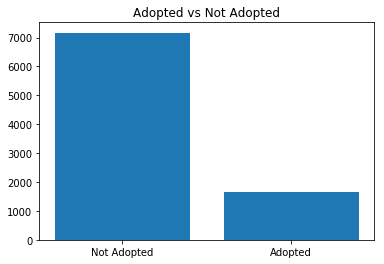

In [312]:
plt.title('Adopted vs Not Adopted',fontsize=12)
plt.bar(['Not Adopted','Adopted'],outcome.groupby(outcome).count())
plt.show()

In [318]:
#split dataset to test and train
var_train,var_test,out_train,out_test = train_test_split(user,outcome,test_size=0.3, random_state=0)

In [331]:
#instantiate a classifier with out of box settings.
rf = RandomForestClassifier(random_state=0)

#fit train data
rf.fit(var_train,out_train)

#predict outcome
rf_prediction = rf.predict(var_test)

#model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(out_test, rf_prediction))

Accuracy: 0.8073290517567057


/Users/byungchankim/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/byungchankim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [333]:
#define column names for feature importance
col_names = user.columns

print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), col_names), reverse=True))

[(0.3764, 'src_guest_invite'), (0.162, 'opted_in_to_mailing_list'), (0.1411, 'enabled_for_marketing_drip'), (0.1028, 'src_signup'), (0.0976, 'src_personal_projects'), (0.0507, 'invited'), (0.0451, 'src_signup_google_auth'), (0.0244, 'src_org_invite')]


**Result**

From the outcome, it looks like users who signed up with guest_invite are the ones most likely to become adopted users.  <br>
If the users are opted in for various marketing materials, they have higher chance of becoming adopted users as well.


**Remark**

Without time constraint and higher computing power, it may be worthwhile to further feature engineer the data to account for below:

- invited_by_user : are users more likely to adopt if they are invited by certain group of users?
- org_id : are users more likely to adopt if they are part of certain orgs?
- last_session : are users who have logged during certain timeframe more likely to adopt?